In [1]:
import sys
# sys.path.insert(0, "../input/timm-efficientdet-pytorch")
# sys.path.insert(0, "../input/omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pickle
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=4, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [3]:
label_codes = {
"Pedestrian": 0,
"Biker": 1,
"Car": 2,
"Bus": 3,
"Skater": 4,
"Cart": 5
}
label_colors = {
0: (1,0,0),
1:(0,1,0),
2: (0,0,1),
 3: (1,1,0),
4:(0,1,1),
5:(1,1,1)
}

In [4]:
# with open('train_dataset.df', 'wb') as f:
#     pickle.dump(train_dataset.df, f)
# with open('train_dataset.df', 'rb') as f:
#     df = pickle.load(f)

In [5]:
TRAIN_ROOT_PATH = '/mnt/r4/aliev/stanford_voc/JPEGImages'

class DatasetRetriever(Dataset):

    def __init__(self,  transforms=None, test=False):
        super().__init__()
        self.debug = False
        self.transforms = transforms
        self.test = test
        self.label_codes = {
		"Pedestrian": 0,
		"Biker": 1,
		"Car": 2,
		"Bus": 3,
		"Skater": 4,
		"Cart": 5
        }

        root_dir = '/mnt/r4/aliev/annotations/'
#         files = glob.glob(root_dir + '/**/*.txt', recursive=True)

#         l = []
#         colnames = ['track_id', 'xmin','ymin','xmax','ymax','frame','lost','occluded','generated','label']
#         for file in files:
#             prefix = file.split('/')[5]+'_'+file.split('/')[6]+'_'
#             df_temp = pd.read_csv(file, delimiter = " ",names=colnames)
#             df_temp['image_path'] = prefix+df_temp['frame'].astype('string')
#             l.append(df_temp)

#         self.df = pd.concat(l,ignore_index=True)
        with open('train_dataset.df', 'rb') as f:
            self.df = pickle.load(f)
        images = pd.read_csv('/mnt/r4/aliev/stanford_voc/ImageSets/Main/train.txt',names = ['fname'])
        self.image_ids = list(images.fname)


    def setDebug(self,debug):
        self.debug = debug
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image, boxes,labels = self.load_image_and_boxes(index)
#         if self.test or random.random() > 0.5:
#             image, boxes = self.load_image_and_boxes(index)
#         else:
#             image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    return image, target, image_id
                    
        target['boxes'] = torch.empty((0,4))
        return sample['image'],target,labels

#         return image, target, image_id

    def __len__(self) -> int:
        return len(self.image_ids)

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        filename = f'{TRAIN_ROOT_PATH}/{image_id}.jpg'
        if self.debug:
            print('file: ',filename)
        image = cv2.imread(filename, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.df[(self.df['image_path'] == image_id) & (self.df['lost']==0) &  (self.df['occluded']==0)]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = torch.tensor([label_codes[i] for i in records.astype('string')['label']],dtype=torch.int64)
#         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes,labels

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [6]:
fold_number = 0

train_dataset = DatasetRetriever(
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    transforms=get_valid_transforms(),
    test=True,
)

In [7]:
# train_dataset.setDebug(True)
train_dataset.df

,track_id,xmin,ymin,xmax,ymax,frame,lost,occluded,generated,label,image_path
450770,0,0,0,41,59,10162,0,0,1,Biker,coupa_video0_10162
450773,0,0,0,55,59,10165,0,0,1,Biker,coupa_video0_10165
450776,0,0,0,68,59,10168,0,0,1,Biker,coupa_video0_10168
450779,0,0,0,85,59,10171,0,0,0,Biker,coupa_video0_10171
450782,0,5,0,90,59,10174,0,0,1,Biker,coupa_video0_10174
...,...,...,...,...,...,...,...,...,...,...,...
10321283,60,627,1951,684,2014,1367,0,0,1,Biker,little_video0_1367
10321284,60,629,1951,686,2014,1368,0,0,1,Biker,little_video0_1368
10321285,60,629,1955,686,2014,1369,0,0,1,Biker,little_video0_1369
10321286,60,629,1955,686,2014,1370,0,0,1,Biker,little_video0_1370


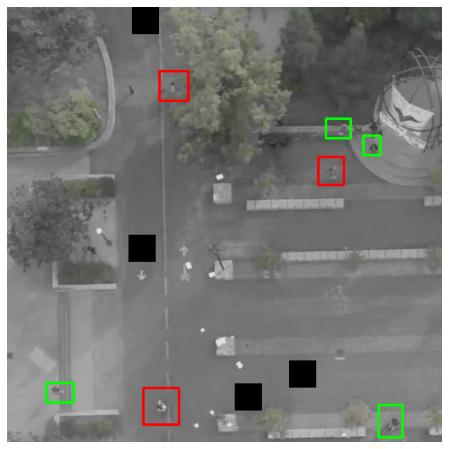

In [8]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)
labels = target['labels'].cpu().numpy()
numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for box,label in zip(boxes,labels):
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), label_colors[label], 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [11]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 2 
    n_epochs = 3 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [13]:
#for pip version
# from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
# from effdet.efficientdet import HeadNet
# config = get_efficientdet_config('tf_efficientdet_d0')

# config.image_size = [512,512]
# config.norm_kwargs=dict(eps=.001, momentum=.01)

# net = EfficientDet(config, pretrained_backbone=False)
# checkpoint = torch.load('efficientdet_d0-d92fd44f.pth')
# net.load_state_dict(checkpoint)


# net.reset_head(num_classes=6)
# net.class_net = HeadNet(config, num_outputs=config.num_classes)

# DetBenchTrain(net, config)

In [14]:
import torch
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d0')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('efficientdet_d0-d92fd44f.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 6
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()


In [17]:
train_dataset.setDebug(False)

In [ ]:
device = torch.device('cuda:0')
net.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TrainGlobalConfig.batch_size,
    sampler=RandomSampler(train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=TrainGlobalConfig.num_workers,
    collate_fn=collate_fn,
)
val_loader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=TrainGlobalConfig.batch_size,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(validation_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
fitter.fit(train_loader, val_loader)

Fitter prepared. Device is cuda:0

2021-05-27T07:15:27.923815
LR: 0.0002


In [ ]:
train_dataset.image_ids()

In [ ]:
train_dataset.image_ids.index('coupa_video0_11128.jpg')

In [ ]:
fname = '/mnt/r4/aliev/stanford_voc/JPEGImages/bookstore_video1_4.jpg'
image = cv2.imread(fname, cv2.IMREAD_COLOR)


In [ ]:
plt.imshow(image)

In [ ]:
type(images[0])